In [1]:
!pip install torchvision numpy scipy pillow matplotlib


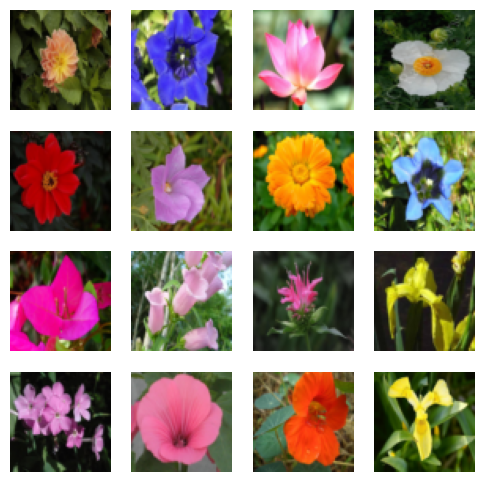

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1,1] for GANs
])

# Download the Oxford Flowers dataset
dataset = torchvision.datasets.Flowers102(root="./data", split="train", download=True, transform=transform)

# Load dataset
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Show some images
def show_images(data_loader):
    images, _ = next(iter(data_loader))
    images = images[:16]  # Take first 16 images
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        img = images[i].permute(1, 2, 0)  # Change shape to (H, W, C)
        img = (img + 1) / 2  # Denormalize
        ax.imshow(img)
        ax.axis("off")
    plt.show()

# Display sample images
show_images(data_loader)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class RBM(nn.Module):
    def __init__(self, visible_units, hidden_units):
        super(RBM, self).__init__()
        self.visible_units = visible_units
        self.hidden_units = hidden_units
        
        # Initialize weights with Xavier initialization for stability
        self.W = nn.Parameter(torch.randn(hidden_units, visible_units) * 0.01)
        
        # Bias terms
        self.v_bias = nn.Parameter(torch.zeros(visible_units))  # Visible layer bias
        self.h_bias = nn.Parameter(torch.zeros(hidden_units))   # Hidden layer bias
    
    def sample_hidden(self, v):
        """Compute hidden probabilities & sample hidden states (Gaussian-Bernoulli)."""
        h_prob = torch.sigmoid(torch.matmul(v, self.W.t()) + self.h_bias)
        h_sample = h_prob + torch.randn_like(h_prob) * 0.1  # Add Gaussian noise
        return h_sample

    def sample_visible(self, h):
        """Compute visible probabilities & sample visible states."""
        v_prob = torch.sigmoid(torch.matmul(h, self.W) + self.v_bias)
        v_sample = torch.bernoulli(v_prob)
        return v_sample

    def forward(self, v):
        """Forward pass to get hidden representation."""
        return self.sample_hidden(v)

    def contrastive_divergence(self, v0, k=3):
        """Train RBM using Contrastive Divergence (CD-k)."""
        v = v0.detach()  # Detach from computation graph for stability
        for _ in range(k):
            h = self.sample_hidden(v)
            v = self.sample_visible(h)
        
        h0 = self.sample_hidden(v0)
        hk = self.sample_hidden(v)

        return h0, hk, v

    def train_rbm(self, data_loader, epochs=5, lr=0.005):
        """Train the RBM on image dataset."""
        optimizer = optim.Adam(self.parameters(), lr=lr)  # Adam is more stable than SGD
        
        for epoch in range(epochs):
            epoch_loss = 0
            for images, _ in data_loader:
                images = images.view(images.size(0), -1)  # Flatten images
                images = images.to(self.W.device)  # Ensure correct device

                h0, hk, v_recon = self.contrastive_divergence(images)

                # Compute weight update using PyTorch autograd
                optimizer.zero_grad()
                loss = torch.mean((images - v_recon) ** 2)  # Reconstruction loss
                loss.backward()
                optimizer.step()
z
                epoch_loss += loss.item()

            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Initialize RBM
visible_units = 64 * 64 * 3  # Image size (64x64 RGB)
hidden_units = 1024  # Increase hidden units for better feature learning
rbm = RBM(visible_units, hidden_units)

# Train RBM on the Oxford Flowers dataset
rbm.train_rbm(data_loader, epochs=20, lr=0.001)  


Epoch 1/20, Loss: 17.8421
Epoch 2/20, Loss: 17.8464
Epoch 3/20, Loss: 17.8528
Epoch 4/20, Loss: 17.8396
Epoch 5/20, Loss: 17.8477
Epoch 6/20, Loss: 17.8407
Epoch 7/20, Loss: 17.8430
Epoch 8/20, Loss: 17.8417
Epoch 9/20, Loss: 17.8366
Epoch 10/20, Loss: 17.8441
Epoch 11/20, Loss: 17.8424
Epoch 12/20, Loss: 17.8388
Epoch 13/20, Loss: 17.8344
Epoch 14/20, Loss: 17.8446
Epoch 15/20, Loss: 17.8504
Epoch 16/20, Loss: 17.8328
Epoch 17/20, Loss: 17.8452
Epoch 18/20, Loss: 17.8371
Epoch 19/20, Loss: 17.8487
Epoch 20/20, Loss: 17.8490


In [1]:
import torch
import matplotlib.pyplot as plt

def reconstruct_images(rbm, data_loader, num_images=8):
    """Reconstruct and visualize images using the trained RBM."""
    rbm.eval()  # Set RBM to evaluation mode
    device = next(rbm.parameters()).device  # Get RBM device

    images, _ = next(iter(data_loader))  # Take one batch
    images = images[:num_images]  # Take a subset
    images = images.view(images.size(0), -1).to(device)  # Flatten and move to device

    # Pass images through RBM
    with torch.no_grad():
        h = rbm.sample_hidden(images)  # Get hidden representation
        v_recon = rbm.sample_visible(h)  # Reconstruct visible layer

    # Reshape for visualization
    images = images.view(-1, 3, 64, 64).cpu()
    v_recon = v_recon.view(-1, 3, 64, 64).cpu()

    # Display original and reconstructed images
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
    for i in range(num_images):
        axes[0, i].imshow((images[i].permute(1, 2, 0) + 1) / 2)  # Denormalize
        axes[0, i].axis("off")
        axes[1, i].imshow((v_recon[i].permute(1, 2, 0) + 1) / 2)  # Denormalize
        axes[1, i].axis("off")

    axes[0, 0].set_title("Original")
    axes[1, 0].set_title("Reconstructed")
    plt.show()

# Call the function after training the RBM
reconstruct_images(rbm, data_loader)


NameError: name 'rbm' is not defined

In [23]:
def extract_rbm_features(rbm, data_loader):
    """Extract RBM hidden activations for the dataset (without device handling)."""
    rbm_features = []

    for images, _ in data_loader:
        images = images.view(images.size(0), -1)  # Flatten images

        # Normalize images (Convert to range [-1, 1] for GAN stability)
        images = (images - 0.5) / 0.5  

        # Extract RBM features (Use continuous activations instead of hard samples)
        hidden_activations = torch.sigmoid(rbm.forward(images))  # Smooth features

        # Store extracted features
        rbm_features.append(hidden_activations.detach().float())

    # Stack extracted features
    rbm_features = torch.cat(rbm_features, dim=0)  

    # Normalize RBM Features to have a Mean of 0 and Std of 1
    rbm_features = (rbm_features - rbm_features.mean()) / rbm_features.std()

    return rbm_features

# Extract RBM features
rbm_features = extract_rbm_features(rbm, data_loader)
print("Extracted RBM Feature Shape:", rbm_features.shape)  # Should be (N, hidden_units)


Extracted RBM Feature Shape: torch.Size([1020, 1024])


In [27]:
class Generator(nn.Module):
    def __init__(self, input_dim):  # Only one argument
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (512, 4, 4)),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [30]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc = nn.Linear(256 * 8 * 8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv_blocks(x).view(-1, 256 * 8 * 8)
        return self.sigmoid(self.fc(x))


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Generator & Discriminator
input_dim = rbm.hidden_units  # RBM feature size
generator = Generator(input_dim).to(device)
discriminator = Discriminator().to(device)  # No need for (3) if input size is fixed

# Loss function & Optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training Loop
epochs = 100
batch_size = 64

generator.train()
discriminator.train()

for epoch in range(epochs):
    for batch_idx, (real_images, _) in enumerate(data_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        
        # ---- Train Discriminator ----
        optimizer_D.zero_grad()
        real_labels = torch.empty(batch_size, 1, device=device).uniform_(0.85, 1.0)  # Smoother labels
        fake_labels = torch.empty(batch_size, 1, device=device).uniform_(0.0, 0.15)

        real_loss = criterion(discriminator(real_images), real_labels)

        # Get RBM features for this batch
        rbm_input = rbm_features[batch_idx * batch_size : (batch_idx + 1) * batch_size].to(device)
        if rbm_input.shape[0] != batch_size:
            continue  # Skip inconsistent batch sizes

        # Generate fake images from RBM features
        fake_images = generator(rbm_input).view(batch_size, 3, 64, 64)  # Reshape correctly

        fake_loss = criterion(discriminator(fake_images.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # ---- Train Generator ----
        optimizer_G.zero_grad()
        gen_labels = torch.full((batch_size, 1), 1.0, device=device)  # Fool discriminator
        g_loss = criterion(discriminator(fake_images), gen_labels)
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch {epoch+1}/{epochs}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")


Epoch 1/100, D Loss: 3.6613, G Loss: 3.4772
Epoch 2/100, D Loss: 2.1019, G Loss: 4.6516
Epoch 3/100, D Loss: 1.1750, G Loss: 4.4373
Epoch 4/100, D Loss: 1.4913, G Loss: 5.4923
Epoch 5/100, D Loss: 0.9684, G Loss: 3.7716
Epoch 6/100, D Loss: 1.4830, G Loss: 3.2091
Epoch 7/100, D Loss: 1.1164, G Loss: 2.3359
Epoch 8/100, D Loss: 0.8894, G Loss: 2.6022
Epoch 9/100, D Loss: 0.9827, G Loss: 2.8212
Epoch 10/100, D Loss: 1.1619, G Loss: 2.3937
Epoch 11/100, D Loss: 0.7212, G Loss: 3.2613
Epoch 12/100, D Loss: 0.9014, G Loss: 4.3171
Epoch 13/100, D Loss: 0.8052, G Loss: 3.4180
Epoch 14/100, D Loss: 0.8893, G Loss: 2.3137
Epoch 15/100, D Loss: 0.8924, G Loss: 4.3778
Epoch 16/100, D Loss: 1.5076, G Loss: 3.0267
Epoch 17/100, D Loss: 0.8066, G Loss: 5.1132
Epoch 18/100, D Loss: 0.8786, G Loss: 5.0716
Epoch 19/100, D Loss: 0.8711, G Loss: 4.8579
Epoch 20/100, D Loss: 1.3860, G Loss: 5.3384
Epoch 21/100, D Loss: 1.0807, G Loss: 3.0698
Epoch 22/100, D Loss: 0.9135, G Loss: 2.9432
Epoch 23/100, D Los

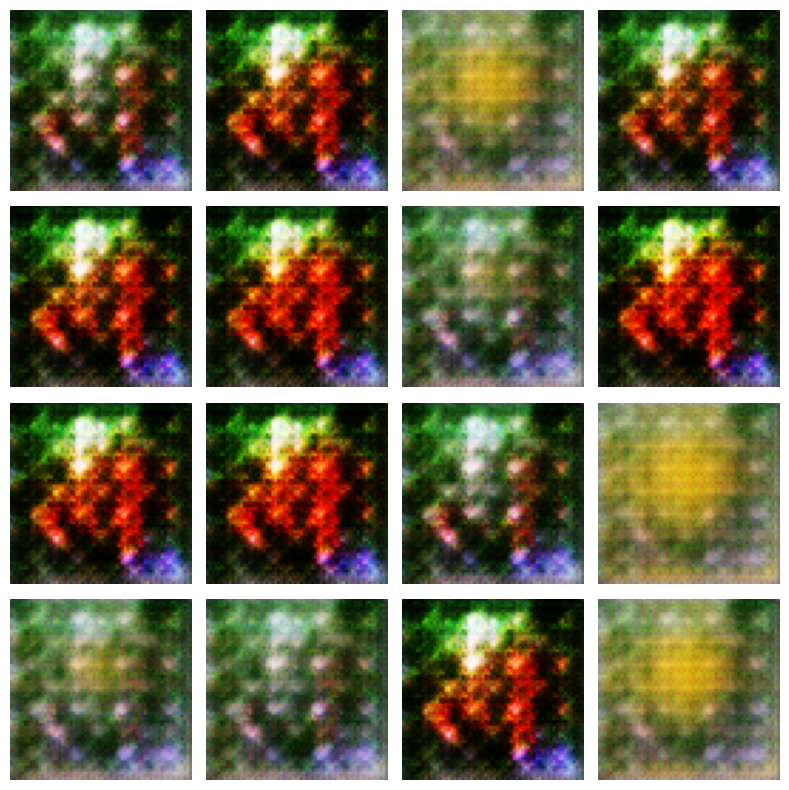

In [35]:
import torch
import matplotlib.pyplot as plt

def generate_images(generator, rbm_features, num_images=16):
    """Generate and visualize i mages using the trained Generator."""
    generator.eval()  # Set generator to evaluation mode
    
    # Ensure rbm_features are on the same device as the generator
    device = next(generator.parameters()).device
    rbm_features = rbm_features[:num_images].to(device)

    with torch.no_grad():
        fake_images = generator(rbm_features)  # Generate images
        fake_images = fake_images.view(num_images, 3, 64, 64)  # Reshape to (C, H, W)
        fake_images = (fake_images + 1) / 2  # Normalize from [-1,1] to [0,1]
        fake_images = fake_images.clamp(0, 1)  # Ensure values are in valid range

    # Display generated images
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            img = fake_images[i].permute(1, 2, 0).cpu().numpy()  # Convert to NumPy format
            ax.imshow(img)
            ax.axis("off")
        else:
            ax.set_visible(False)

    plt.tight_layout()
    plt.show()

# Generate and display fake flower images
generate_images(generator, rbm_features)


In [10]:
print("Min pixel value:", fake_images.min().item())
print("Max pixel value:", fake_images.max().item())


Min pixel value: -0.20491458475589752
Max pixel value: 0.13507920503616333


In [11]:
print("RBM Features Shape:", rbm_features.shape)
print("RBM Features Sample:", rbm_features[:5])


RBM Features Shape: torch.Size([1020, 512])
RBM Features Sample: tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])


In [38]:
torch.save(generator.state_dict(), "generator.pth")
torch.save(rbm.state_dict(), "rbm.pth")


In [39]:
generator.load_state_dict(torch.load("generator.pth"))
rbm.load_state_dict(torch.load("rbm.pth"))
generator.eval()  # Set to evaluation mode


Generator(
  (model): Sequential(
    (0): Linear(in_features=1024, out_features=8192, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(512, 4, 4))
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from torchvision.models import inception_v3
from torch.nn.functional import softmax

def inception_score(generator, rbm_features, num_images=100):
    generator.eval()
    
    device = next(generator.parameters()).device
    rbm_features = rbm_features[:num_images].to(device)

    with torch.no_grad():
        fake_images = generator(rbm_features)
        fake_images = (fake_images + 1) / 2  # Normalize to [0, 1]

    # Ensure images are resized correctly to (299, 299) for InceptionV3
    fake_images_resized = F.interpolate(fake_images, size=(299, 299), mode='bilinear', align_corners=False)

    # Load pre-trained InceptionV3 model
    inception = inception_v3(pretrained=True, transform_input=False).to(device)
    inception.eval()

    # Get softmax predictions
    preds = softmax(inception(fake_images_resized), dim=1).cpu().detach().numpy()

    # Compute KL-divergence
    py = preds.mean(axis=0)  # Average prediction distribution
    kl_div = preds * (np.log(preds) - np.log(py))
    score = np.exp(kl_div.sum(axis=1).mean())

    return score

# Compute Inception Score
print(f"Inception Score: {inception_score(generator, rbm_features):.2f}")
